# Classification of Tanzanian Water Well Status
* This notebook is from my participation in [Driven Data's competition](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/). This first notebook will be about exploring and cleaning the data.

## Import Data

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Join Training labels and values into single DF by there ID
df = pd.read_csv('./Data/Test Set Values.csv').set_index('id')
print(df.shape)


(14850, 39)


In [3]:
# # Import training data labels into df
# training_df_labels = pd.read_csv('./Data/Training Set Labels.csv').set_index(
#     'id')

# # Preview the Dataframe
# training_df_labels.head()

In [4]:
# # Join Training labels and values into single DF by there ID
# df = training_df.join(training_df_labels, on='id')
# print(df.shape)

# # Validate if we still have all the same columns still
# len(df.columns) == len(training_df.columns) + len(training_df_labels.columns)

## This Data is Training Data Only
The data has already been split by Driven Data. They have given me 3 different data frames, training values, training labels, and test values. The output must create a CSV file with the id and predicted labels which they will score for me. Due to this already being split into train and test data I can go ahead with data preparation tasks without worrying about data leakage. 

In [5]:
#
## Use Pandas Profile to view  an inline quick overall summary of the data
#training_profile = ProfileReport(df,
#                                 title='EDA of Water Well Data',
#                                 explorative=True,
#                                 html={'style': {
#                                     'full_width': True
#                                 }})
#training_profile.to_notebook_iframe()
#
## Send the profile to HTML to be viewed fullscreen
#training_profile.to_file("./Data/WaterWell_EDA.html")

# Data Cleaning - Low Hanging Fruit

## Step 1: Delete Zero Variance Predictors
 - Pandas Profile alerted us that 'recorded_by' is a constant value for all observations
 - We can immediately delete this row as it will not help us make predictions

In [6]:
# Count numbers of unique values double checking pandas profiler
counts = df.nunique()

# Identify columns with a constant vale (zero variance)
zero_variance_predictors = [
    df.columns[i] for i, v in enumerate(counts) if v == 1
]

# Delete identified zero variance columns from our main data frame
df = df.drop(columns=zero_variance_predictors)

## Section 2: Identify Near-Zero Variance Predictors
- We are looking for numerical values that have very few distinct values
- This is different than ordinal or categorical values with very few predictors
- Pandas Profile has alerted us to some of this we will double check in this section


In [7]:
# # Create empty list to save names to drop columns later
near_zero_variance_predictors = []

# # This list is to collect column names to be dropped at the end of this Step
near_zero_variance_drop_list = []

# # summarize the number of unique values in each column
# for i in range(df.shape[1]):
# #    # Number of unique values in that column
#     num = df.nunique()[i]
# #    # Percentage of unique values to total
#     percentage = float(num) / df.shape[0] * 100
# #    # Get name of column
#     name = df.columns[i]
# #    # Save name of column to a list oustide of for loop
#     near_zero_variance_predictors.append(name)
#     if percentage < 1:
#         print('%d, %d, %.1f%%, %s' % (i, num, percentage, name))

### 2.1 Further Examination of Near Zero Variace Predictors
- Most of these columns are categorical
- We are *only* looking to eliminate the numerical values with very vew data points such as 'amount_tsh' at this step
- Date Recorded should be a different data type we will analyze later

Using our pandas profile output we will evaluate which of these are numeric or categorical. At this time we will not analyze the categorical data. Num_private is binary and has no description so it can be removed without hesitation. The following columns are numeric and will be examined further:
- amount_tsh
- num_private (No good description of this predictor)
- Year constructed


#### 2.1.1 Exploration of amount_tsh column
- Static head is the difference in height of the water level in the well and the top of the pump
- The higher the head the less energy it takes to pump water up
- Potentially positive static head could be an indicator of wells that do not need to be repaired
- My theory is some "repairs" have to deal with drilling a new water well because the last one is dried up

In the two bar charts below we can see there is a strong difference in the positive head data set and no static head. The ratio of functional to non-functional is much better in the positive head column. We can turn this column into a binary column showing a positive recorded static head or not.

In [8]:
# # Create dataframe with positive static head to use for analysis
# postive_tsh_df = df.loc[df.amount_tsh > 0]

# # Group df by status group and get counts for each status group
# positive_tsh_groups = postive_tsh_df.groupby(df.status_group).count()

# # Plot graph of positive total static head
# sns.barplot(x=['funtional', 'functional needs repair', 'non functional'],
#             y=positive_tsh_groups.status_group)

# # Update Y axis name
# plt.ylabel('Count of wells')

# # Update Plot Title
# plt.title('Wells with a positive static head')

In [9]:
# # Create dataframe with no static head to use for analysis
# no_tsh_df = df.loc[df.amount_tsh <= 0]

# # Group df by status group and get counts for each status group
# no_tsh_groups = no_tsh_df.groupby(df.status_group).count()

# # Plot graph of positive total static head
# sns.barplot(x=['functional', 'functional needs repair', 'non functional'],
#             y=no_tsh_groups.status_group)

# # Update Y axis name
# plt.ylabel('Count of wells')

# # Update Plot Title
# plt.title('Wells with a no static head')

#### 2.1.2 Num_Private Analysis
We have no data description of what this column is. Without any good description data I do not feel comfortable using this data in a model so we will remove this column from our dataset.

In [10]:
# View Counds of values
df.num_private.value_counts()

near_zero_variance_drop_list.append('num_private')

#### 2.1.3 Year Constructed Analysis
The year constructed could give us some valuable insights so it may be wise not to drop this predictor. It will not have many unique values as it is interval data. In the cells below I have plotted the number of wells over time by their current status grouping. My initial hypothesis is that the more recently constructed wells will still be working and the older wells will not.

We may turn this into a binary function with an arbitrary cutoff date. For example, wells constructed after the year 2000 or before. My guess is the majority of wells that do not have a constructed date are probably older. 


In [11]:
# # Create a grouped data frame to get the number and status of wells constructed that year
# constructed_year_df = df.loc[df.construction_year > 0].groupby(
#     [df.construction_year, df.status_group]).count()

# # Remove all other columns except status group column for our data frame
# constructed_year_df = constructed_year_df.loc[:, ['status_group']]

# # Rename 'status_group' to count showing the count of wells that year in that particular status group
# constructed_year_df.rename(columns={'status_group': 'count'}, inplace=True)

# # Reset index to select status groups independently
# constructed_year_df.reset_index(inplace=True)

*Create the line graphs*

In [12]:
# # Get Y values for functional status group
# functional = constructed_year_df.loc[constructed_year_df.status_group ==
#                                      'functional']

# # Get Y values for functional needs repair group
# functional_needs_repair = constructed_year_df.loc[
#     constructed_year_df.status_group == 'functional needs repair']

# # This array only is missing data for 1966 so we are putting in a placeholder of 0 so we can plot
# functional_needs_repair.loc[-1] = [1966, 'functional needs repair', 0]

# # Sort this array so that 1966 placeholder goes where it belongs
# functional_needs_repair.sort_values('construction_year', inplace=True)

# # Get Y values for non functional status group
# non_functional = constructed_year_df.loc[constructed_year_df.status_group ==
#                                          'non functional']

# # Get X values for plot
# year_constructed = constructed_year_df.construction_year.unique()

# # Plot functional status group over years
# plt.plot(year_constructed, functional['count'], label='functional')

# # Plot functional but needs repair status group over years
# plt.plot(year_constructed,
#          functional_needs_repair['count'],
#          label='functional needs repair')

# # Plot non functional status group over years
# plt.plot(year_constructed, non_functional['count'], label='non functional')
# plt.title('Number of wells Cosntructed based on their current Status')
# plt.xlabel('Year well was constructed')
# plt.ylabel('Number of wells')
# plt.legend()
# plt.figure(figsize=(20, 20))

### 2.3 Dropping Near Zero Variance Columns

In [13]:
# Drop near zero variant columns
df.drop(columns=near_zero_variance_drop_list, inplace=True)

# Section 3 Numerical Data Analysis and Cleaning

In [14]:
# Look at pandas profile and pull all columns that are Real Numbers that we have not eliminated
numerical_predictors = [
    'amount_tsh', 'date_recorded', 'gps_height', 'longitude', 'latitude',
    'population', 'construction_year',
]

# Create the numerical df
numerical_df = df[numerical_predictors]

# View Data Types
numerical_df.info()

# Keep track of numerical columns to be dropped
numerical_columns_to_drop = []

# Keep track of numercal columns ecvaluated
evaluated_numerical_columns = []

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14850 entries, 50785 to 68707
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         14850 non-null  float64
 1   date_recorded      14850 non-null  object 
 2   gps_height         14850 non-null  int64  
 3   longitude          14850 non-null  float64
 4   latitude           14850 non-null  float64
 5   population         14850 non-null  int64  
 6   construction_year  14850 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 928.1+ KB


### 3.1 Analysis of Amount_TSH Column
We have already determined that this column could potentially be useful by looking at the bar charts we made earlier. We are going to start off with making this a binary column. 
- 1 if it has a positive head 
- 0 if it does not have a head greater than 0

In [15]:
# Add to list of columns that have been evaluated
evaluated_numerical_columns.append('amount_tsh')

# Create a new column changing amount_tsh to a binary column if it has positive head or not
numerical_df['positive_head'] = (numerical_df.amount_tsh > 0).astype(int)

# Update columns to be dropped
numerical_columns_to_drop.append('amount_tsh')

### 3.2 Analysis of Date Recorded Column
- 1st iteration: The date of record should not have any effect on whether the well is working or not. We will remove this column from our data set this iteration.

In [16]:
# Add to list of columns that have been evaluated
evaluated_numerical_columns.append('date_recorded')

# Add this column to drop list
numerical_columns_to_drop.append('date_recorded')

### 3.3 Analysis of Longitude
- Iteration 1: We will remove all NaN values from the dataframe

The number of NaN values: 457
It is 3.08% of the total data


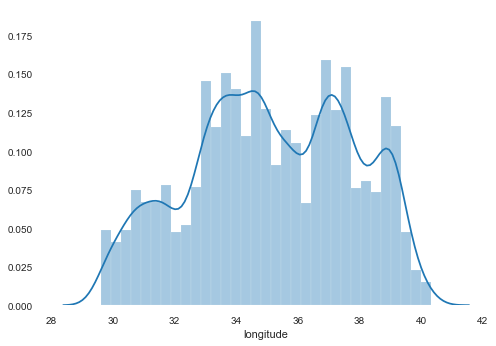

In [17]:
# Add to list of columns that have been evaluated
evaluated_numerical_columns.append('longitude')

# Mark 0 Values as nan as this is a placeholder for bad data
numerical_df.longitude.replace(0, np.nan, inplace=True)

# Print how many variables are NaN and percent
print('The number of NaN values:', numerical_df.longitude.isnull().sum())
print(
    f'It is {(numerical_df.longitude.isnull().sum())/len(numerical_df.longitude):.2%} of the total data'
)

# Drop the NaN Values from the data set
numerical_df.dropna(inplace=True)

# View distribution of longtidal values
sns.distplot(numerical_df.longitude)

### 3.4 Analysis of Latitude
- 1st iteration: Latitude data looks good

count    14393.000000
mean        -5.865223
std          2.804318
min        -11.564592
25%         -8.569461
50%         -5.180883
75%         -3.366969
max         -0.998752
Name: latitude, dtype: float64

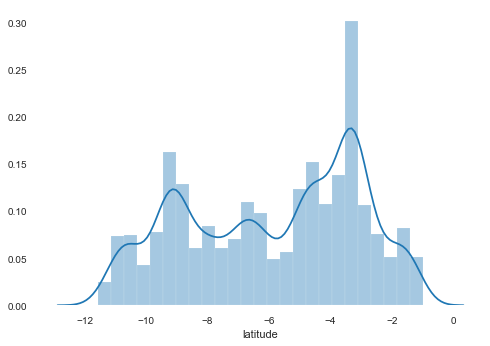

In [18]:
# Add to list of columns that have been evaluated
evaluated_numerical_columns.append('latitude')

# View distribution of values to see if there are outliers
sns.distplot(numerical_df.latitude)

# Describe the data to find anomalies
numerical_df.latitude.describe()

### 3.5 Analysis of Population around well
- 1st Iteration - I have decided to do a simple binning for population as 36% of the observations have a population of 0. My initial theory is that the wells with a lot less (or none) people will have a higher chance of being non functional. 

In [19]:
# Add to list of columns that have been evaluated
evaluated_numerical_columns.append('population')

# Create labels to easily identify what size population lives at that well
#population_cut_labels = [
#    'no people', 'under 1000', '1000+'
#]

# Create bin ranges for population segments
#population_bins = [0, 1, 1000, numerical_df.population.max()]

# Create new categorical column called population size and use 'cut' to create the bins
#numerical_df['population_size'] = pd.cut(numerical_df['population'],
#                                         bins=population_bins,
#                                         labels=population_cut_labels,
#                                         include_lowest=True)

# View the results of the binning
#numerical_df.population_size.value_counts()

# Update columns to be dropped
numerical_columns_to_drop.append('population')

In [20]:
#numerical_df.groupby(['population_size','status_group']).status_group.count().sort_values().plot(kind='bar',)

### 3.6 Analysis of Construction Year
- 1st iteration: I have decided to make this into categorical data by binning the years into decades with 0 being a no data column

In [21]:
# Add to list of columns that have been evaluated
evaluated_numerical_columns.append('construction_year')

# Create labels to easily identify what size population lives at that well
construction_decade_labels = [
    'no data', '1960s', '1970s', '1980s', '1990s', '2000s', '2010+'
]

# Create bin ranges for population segments
construction_decade_bins = [
    0, 1, 1969, 1979, 1989, 1999, 2009,
    numerical_df.construction_year.max()
]

# Create new categorical column called population size and use 'cut' to create the bins
numerical_df['construction_decade'] = pd.cut(numerical_df['construction_year'],
                                             bins=construction_decade_bins,
                                             labels=construction_decade_labels,
                                             include_lowest=True)

# View the results of the binning
numerical_df.construction_decade.value_counts()

# Update columns to be dropped
numerical_columns_to_drop.append('construction_year')

### 3.7 Check Numerical Columns evaluated and to be dropped in Section 3

In [22]:
# View which columns will be dropped
print('Columns to be dropped:',numerical_columns_to_drop)


# Look at main df and select only the categorical values we have left
# yields the elements in `list_2` that are NOT in `list_1`
print('Columns that were missed in evaluation:',np.setdiff1d(evaluated_numerical_columns, numerical_df.columns))



Columns to be dropped: ['amount_tsh', 'date_recorded', 'population', 'construction_year']
Columns that were missed in evaluation: []


# Section 4 Categorical Data

In [23]:
# Look at main df and select only the categorical values we have left
# yields the elements in `list_2` that are NOT in `list_1`
categorical_column_list = np.setdiff1d(df.columns, numerical_df.columns)

# Create the categorical dataframe
categorical_df = df[categorical_column_list]

# Add the target labels to df
#categorical_df['status_group'] = df.status_group

# View Data Types
categorical_df.info()

# Initialize empty list of column names to drop at the end of this section
categorical_to_drop_list = []

# Create an empty list to keep track of columns that have been evaluated
categorical_columns_evaluated = []

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14850 entries, 50785 to 68707
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   basin                  14850 non-null  object
 1   district_code          14850 non-null  int64 
 2   extraction_type        14850 non-null  object
 3   extraction_type_class  14850 non-null  object
 4   extraction_type_group  14850 non-null  object
 5   funder                 13981 non-null  object
 6   installer              13973 non-null  object
 7   lga                    14850 non-null  object
 8   management             14850 non-null  object
 9   management_group       14850 non-null  object
 10  payment                14850 non-null  object
 11  payment_type           14850 non-null  object
 12  permit                 14113 non-null  object
 13  public_meeting         14029 non-null  object
 14  quality_group          14850 non-null  object
 15  quantity       

### 4.1 Highly Correlated Categories
The following warnings have been generated in our pandas profile
- extraction_type_group is highly correlated with extraction_type and 1 other fields
- extraction_type is highly correlated with extraction_type_group and 1 other fields
- extraction_type_class is highly correlated with extraction_type and 1 other fields
- management_group is highly correlated with management
- payment_type is highly correlated with payment
- quality_group is highly correlated with water_quality
- water_quality is highly correlated with quality_group
- quantity_group is highly correlated with quantity
- quantity is highly correlated with quantity_group
- source_type is highly correlated with source and 1 other fields
- source_class is highly correlated with source and 1 other fields
- waterpoint_type_group is highly correlated with waterpoint_type



#### 4.1.1 Extraction* Correlated group
Here we will explore the three correlated predictors that have to do with extraction

- 1st iteration we will use the simplest form and go with extraction_type_class
- 2nd iteration we will use extraction_type_class

In [24]:
# View the unique value counts on the data and print missing values
# 'extraction_type'
print(categorical_df.extraction_type.value_counts())
print('Missing Value Count:', categorical_df.extraction_type.isnull().sum())
print('*' * 100)

# View the unique value counts on the data and print missing values
# 'extraction_type_class'
print(categorical_df.extraction_type_class.value_counts())
print('Missing Value Count:',
      categorical_df.extraction_type_class.isnull().sum())
print('*' * 100)

# View the unique value counts on the data and print missing values
# 'extraction_type_group'
print(categorical_df.extraction_type_group.value_counts())
print('Missing Value Count:',
      categorical_df.extraction_type_group.isnull().sum())

# Create list to concatenate onto drop list
extraction_drop_list = ['extraction_type', 'extraction_type_group']

# Add the other columns to drop
categorical_to_drop_list = categorical_to_drop_list + extraction_drop_list

# Add to the list to keep track of columns evaluated
categorical_columns_evaluated = categorical_columns_evaluated + [
    'extraction_type', 'extraction_type_class', 'extraction_type_group'
]

gravity              6483
nira/tanira          2051
other                1672
submersible          1218
swn 80                918
mono                  763
india mark ii         629
afridev               438
ksb                   375
other - rope pump     121
other - swn 81         55
india mark iii         37
windmill               35
cemo                   18
other - play pump      16
walimi                 12
climax                  9
Name: extraction_type, dtype: int64
Missing Value Count: 0
****************************************************************************************************
gravity         6483
handpump        4156
other           1672
submersible     1593
motorpump        790
rope pump        121
wind-powered      35
Name: extraction_type_class, dtype: int64
Missing Value Count: 0
****************************************************************************************************
gravity            6483
nira/tanira        2051
other              1672
submersible  

#### 4.1.2 Management and Management_Group
As with the extraction correlated group we will use the predictor with the fewest features to help set a base case.

- 1st iteration - Use simplest group so we will use management_group

In [25]:
# View the unique value counts on the data and print missing values
# 'management'
print(categorical_df.management.value_counts())
print('Missing Value Count:', categorical_df.management.isnull().sum())
print('*' * 100)

# View the unique value counts on the data and print missing values
# 'management_group'
print(categorical_df.management_group.value_counts())
print('Missing Value Count:', categorical_df.management_group.isnull().sum())

# Add to the section's drop list
categorical_to_drop_list = categorical_to_drop_list + ['management']

# Add to the list to keep track of columns evaluated
categorical_columns_evaluated = categorical_columns_evaluated + [
    'management', 'management_group'
]

vwc                 10117
wug                  1593
water board           755
wua                   583
private operator      533
parastatal            461
other                 239
water authority       219
company               174
unknown               122
trust                  27
other - school         27
Name: management, dtype: int64
Missing Value Count: 0
****************************************************************************************************
user-group    13048
commercial      953
parastatal      461
other           266
unknown         122
Name: management_group, dtype: int64
Missing Value Count: 0


#### 4.1.3 Payment and Payment_Type Correlation
These columns are the same data with just a few character difference, but no difference in data. We can remove one of these columns without hesitation.
- Remove 'payment'

In [26]:
# View the unique value counts on the data and print missing values
# 'payment'
print(categorical_df.payment.value_counts())
print('Missing Values:', categorical_df.payment.isnull().sum())

print('*' * 100)

# View the unique value counts on the data and print missing values
# 'payment_type'
print(categorical_df.payment_type.value_counts())
print('Missing Values:', categorical_df.payment_type.isnull().sum())

# Add to the section's drop list
categorical_to_drop_list = categorical_to_drop_list + ['payment']

# Add to the list to keep track of columns evaluated
categorical_columns_evaluated = categorical_columns_evaluated + [
    'payment', 'payment_type'
]

never pay                6364
pay per bucket           2281
pay monthly              2097
unknown                  1992
pay annually              928
pay when scheme fails     928
other                     260
Name: payment, dtype: int64
Missing Values: 0
****************************************************************************************************
never pay     6364
per bucket    2281
monthly       2097
unknown       1992
annually       928
on failure     928
other          260
Name: payment_type, dtype: int64
Missing Values: 0


#### 4.1.4 Water Quality and Quality Group
Unlike the other times when going with the column with the least unique features I believe this column holds a lot of important information, such as the salty abandonded

In [27]:
# View the unique value counts on the data and missing values
# 'water_quality'
print(categorical_df.water_quality.value_counts())
print('Missing Values:', categorical_df.water_quality.isnull().sum())

print('*' * 100)

# View the unique value counts on the data and missing values
# 'quality_group'
print(categorical_df.quality_group.value_counts())
print('Missing Values:', categorical_df.quality_group.isnull().sum())

# Add to the section's drop list
categorical_to_drop_list = categorical_to_drop_list + ['quality_group']

# Add to the list to keep track of columns evaluated
categorical_columns_evaluated = categorical_columns_evaluated + [
    'water_quality', 'quality_group'
]

soft                  12687
salty                  1226
unknown                 469
milky                   201
coloured                133
salty abandoned          84
fluoride                 44
fluoride abandoned        6
Name: water_quality, dtype: int64
Missing Values: 0
****************************************************************************************************
good        12687
salty        1310
unknown       469
milky         201
colored       133
fluoride       50
Name: quality_group, dtype: int64
Missing Values: 0


#### 4.1.5 Quantity Group and Quantity

In [28]:
# View the unique value counts on the data and missing values
# 'quantity'
print(categorical_df.quantity.value_counts())
print('Missing Values:', categorical_df.quantity.isnull().sum())

print('*' * 100)

# View the unique value counts on the data and missing values
# 'quantity_group'
print(categorical_df.quantity_group.value_counts())
print('Missing Values:', categorical_df.quantity_group.isnull().sum())

# Add to the section's drop list
categorical_to_drop_list = categorical_to_drop_list + ['quantity_group']

# Add to the list to keep track of columns evaluated
categorical_columns_evaluated = categorical_columns_evaluated + [
    'quantity', 'quantity_group'
]

enough          8336
insufficient    3767
dry             1536
seasonal        1025
unknown          186
Name: quantity, dtype: int64
Missing Values: 0
****************************************************************************************************
enough          8336
insufficient    3767
dry             1536
seasonal        1025
unknown          186
Name: quantity_group, dtype: int64
Missing Values: 0


#### 4.1.6 Source, Source type, Source Group

In [29]:
# View the unique value counts on the data and missing values
# 'source'
print(categorical_df.source.value_counts())
print('Missing Values:', categorical_df.source.isnull().sum())

print('*' * 100)

# View the unique value counts on the data and missing values
# 'source_class'
print(categorical_df.source_class.value_counts())
print('Missing Values:', categorical_df.source_class.isnull().sum())

print('*' * 100)

# View the unique value counts on the data and missing values
# 'source_type'
print(categorical_df.source_type.value_counts())
print('Missing Values:', categorical_df.source_type.isnull().sum())

# Add to the section's drop list
categorical_to_drop_list = categorical_to_drop_list + [
    'quantity', 'source_type'
]

# Add to the list to keep track of columns evaluated
categorical_columns_evaluated = categorical_columns_evaluated + [
    'source', 'source_class', 'source_type'
]

shallow well            4316
spring                  4195
machine dbh             2747
river                   2352
rainwater harvesting     568
hand dtw                 234
lake                     185
dam                      184
other                     49
unknown                   20
Name: source, dtype: int64
Missing Values: 0
****************************************************************************************************
groundwater    11492
surface         3289
unknown           69
Name: source_class, dtype: int64
Missing Values: 0
****************************************************************************************************
shallow well            4316
spring                  4195
borehole                2981
river/lake              2537
rainwater harvesting     568
dam                      184
other                     69
Name: source_type, dtype: int64
Missing Values: 0


#### 4.1.7 waterpoint_type_group and waterpoint_type
- 1st iteration: pointed out earlier I will be going with the more simple 

In [30]:
# View the unique value counts on the data and missing values
# 'waterpoint_type'
print(categorical_df.waterpoint_type.value_counts())
print('Missing Values:', categorical_df.waterpoint_type.isnull().sum())

print('*' * 100)

# View the unique value counts on the data and missing values
# 'waterpoint_type_group'
print(categorical_df.waterpoint_type_group.value_counts())
print('Missing Values:', categorical_df.waterpoint_type_group.isnull().sum())

# Add to the section's drop list
categorical_to_drop_list = categorical_to_drop_list + ['waterpoint_type']

# Add to the list to keep track of columns evaluated
categorical_columns_evaluated = categorical_columns_evaluated + [
    'waterpoint_type', 'waterpoint_type_group'
]

communal standpipe             7106
hand pump                      4396
other                          1630
communal standpipe multiple    1508
improved spring                 175
cattle trough                    34
dam                               1
Name: waterpoint_type, dtype: int64
Missing Values: 0
****************************************************************************************************
communal standpipe    8614
hand pump             4396
other                 1630
improved spring        175
cattle trough           34
dam                      1
Name: waterpoint_type_group, dtype: int64
Missing Values: 0


### 4.2 Analyzing High Cardinality Columns
Here we will analyze the columns that have high cardinality. 
- 'date_recorded'
- 'funder'
- 'installer'
- 'wpt_name'
- 'subvillage'
- 'lga'
- 'ward'
- 'scheme_name'

In [31]:
# Leftover columns List
lefotver_categorical_list = np.setdiff1d(categorical_df.columns,
                                         categorical_columns_evaluated)

# Create a list of High Cardinality columns to evaluate
high_cardinality_columns = [
    'date_recorded', 'funder', 'installer', 'wpt_name', 'subvillage', 'lga',
    'ward', 'scheme_name'
]

In [32]:
lefotver_categorical_list

array(['basin', 'district_code', 'funder', 'installer', 'lga', 'permit',
       'public_meeting', 'region', 'region_code', 'scheme_management',
       'scheme_name', 'subvillage', 'ward', 'wpt_name'], dtype=object)

In [33]:
categorical_df.columns

Index(['basin', 'district_code', 'extraction_type', 'extraction_type_class',
       'extraction_type_group', 'funder', 'installer', 'lga', 'management',
       'management_group', 'payment', 'payment_type', 'permit',
       'public_meeting', 'quality_group', 'quantity', 'quantity_group',
       'region', 'region_code', 'scheme_management', 'scheme_name', 'source',
       'source_class', 'source_type', 'subvillage', 'ward', 'water_quality',
       'waterpoint_type', 'waterpoint_type_group', 'wpt_name'],
      dtype='object')

#### 4.2.1 Date Recorded
- 1st iteration as we saw earlier Date Recorded does not seem to be very helpful at this time and we will drop this column.

In [34]:
# Add this column to the list to keep track of it being evaluated
#categorical_columns_evaluated = categorical_columns_evaluated + [
#    'date_recorded'
#]

# Set data type to datetime
#categorical_df.date_recorded = pd.to_datetime(categorical_df.date_recorded)

# Examine the years of the dates recorded
#categorical_df.date_recorded.dt.year.value_counts()

# Add this to the categorical drop list
#categorical_to_drop_list = categorical_to_drop_list + ['date_recorded']

#### 4.2.2 Funder Data
- 1st iteration used top 5 data

In [35]:
# Add this column to the list to keep track of it being evaluated
categorical_columns_evaluated = categorical_columns_evaluated + ['funder']

# Examine the counts of each category
categorical_df.funder.value_counts()

# Get missing values
print('Missing Values:', categorical_df.funder.isnull().sum())

# Find and create list for top 5 funders
top_funders = categorical_df.funder.value_counts().index.tolist()[:5]

# Print the number of categorical data selected
print('Number of Categories labeled:',len(top_funders))

# if funder not in top_funders list reclassify as 'unkown/other'
categorical_df['top_funders'] = categorical_df.funder.apply(
    lambda x: x if x in top_funders else 'other/unkown')

# Check to make sure there are no missing values in the new columns
print('Missing Values After:',categorical_df.top_funders.isnull().sum())

# What percent of the data is our top 5 funders?
print(f'Percent of data labeled: {categorical_df.funder.value_counts(normalize=True).head(5).sum():.2%}')

# Add this column to the list to keep track of it being evaluated
categorical_columns_evaluated = categorical_columns_evaluated + ['top_funders']

# Add funder to list of columns to be removed
categorical_to_drop_list = categorical_to_drop_list + ['funder']

Missing Values: 869
Number of Categories labeled: 5
Missing Values After: 0
Percent of data labeled: 30.58%


#### 4.2.3 Installer Data
- 1st iteration used top 5 values

In [36]:
# Add this column to the list to keep track of it being evaluated
categorical_columns_evaluated = categorical_columns_evaluated + ['installer']

# Examine the counts of each category
categorical_df.installer.value_counts()

# Get missing values
print('Missing Values:', categorical_df.installer.isnull().sum())

# Find and create list for top 5 installers
top_installers = categorical_df.installer.value_counts().index.tolist()[:5]

# Print the number of categorical data selected
print('Number of Categories labeled:',len(top_installers))

# if installer not in top_installers list reclassify as 'unkown/other'
categorical_df['top_installers'] = categorical_df.installer.apply(
    lambda x: x if x in top_installers else 'other/unkown')

# Check to make sure there are no missing values in the new columns
print('Missing Values After:',categorical_df.top_installers.isnull().sum())

# What percent of the data is our top 5 installers?
print(f'Percent of data labeled: {categorical_df.installer.value_counts(normalize=True).head(5).sum():.2%}')

# Add this column to the list to keep track of it being evaluated
categorical_columns_evaluated = categorical_columns_evaluated + ['top_installers']

# Add installer to list of columns to be removed
categorical_to_drop_list = categorical_to_drop_list + ['installer']

Missing Values: 877
Number of Categories labeled: 5
Missing Values After: 0
Percent of data labeled: 40.36%


#### 4.2.4 Waypoint Data
- 1st iteration used top 5 values


In [37]:
# Add this column to the list to keep track of it being evaluated
categorical_columns_evaluated = categorical_columns_evaluated + ['wpt_name']

# Examine the counts of each category
categorical_df.wpt_name.value_counts()

# Get missing values
print('Missing Values:', categorical_df.wpt_name.isnull().sum())

# Find and create list for top 5 waypoints
top_wpt_names = categorical_df.wpt_name.value_counts().index.tolist()[:5]

# Print the number of categorical data selected
print('Number of Categories labeled:',len(top_wpt_names))

# if funder not in top_wpt_names list reclassify as 'unkown/other'
categorical_df['top_wpt_names'] = categorical_df.wpt_name.apply(
    lambda x: x if x in top_wpt_names else 'other/unkown')

# Check to make sure there are no missing values in the new columns
print('Missing Values After:',categorical_df.top_wpt_names.isnull().sum())

# What percent of the data is our top 5 waypoints?
print(f'Percent of data labeled: {categorical_df.wpt_name.value_counts(normalize=True).head(5).sum():.2%}')

# Add this column to the list to keep track of it being evaluated
categorical_columns_evaluated = categorical_columns_evaluated + ['top_wpt_names']

# Add funder to list of columns to be removed
categorical_to_drop_list = categorical_to_drop_list + ['wpt_name']

Missing Values: 0
Number of Categories labeled: 5
Missing Values After: 0
Percent of data labeled: 11.42%


#### 4.2.5 Subvillage Data
- 1st iteration used top 10 values

In [38]:
# Add this column to the list to keep track of it being evaluated
categorical_columns_evaluated = categorical_columns_evaluated + ['subvillage']

# Examine the counts of each category
categorical_df.subvillage.value_counts()

# Get missing values
print('Missing Values:', categorical_df.subvillage.isnull().sum())

# Find and create list for top 5 subvillages
top_subvillage = categorical_df.subvillage.value_counts().index.tolist()[:10]

# Print the number of categorical data selected
print('Number of Categories labeled:', len(top_subvillage))

# if funder not in top_subvillage list reclassify as 'unkown/other'
categorical_df['top_subvillage'] = categorical_df.subvillage.apply(
    lambda x: x if x in top_subvillage else 'other/unkown')

# Check to make sure there are no missing values in the new columns
print('Missing Values After:', categorical_df.top_subvillage.isnull().sum())

# What percent of the data is our top 5 subvillages?
print(
    f'Percent of data labeled: {categorical_df.subvillage.value_counts(normalize=True).head(len(top_subvillage)).sum():.2%}'
)

# Add this column to the list to keep track of it being evaluated
categorical_columns_evaluated = categorical_columns_evaluated + [
    'top_subvillage'
]

# Add funder to list of columns to be removed
categorical_to_drop_list = categorical_to_drop_list + ['subvillage']

Missing Values: 99
Number of Categories labeled: 10
Missing Values After: 0
Percent of data labeled: 5.41%


#### 4.2.6 Local Government Authority  (lga)
- 1st iteration: used top 5 values

In [39]:
# Add this column to the list to keep track of it being evaluated
categorical_columns_evaluated = categorical_columns_evaluated + ['lga']

# Examine the counts of each category
categorical_df.lga.value_counts()

# Get missing values
print('Missing Values:', categorical_df.lga.isnull().sum())

# Find and create list for top 5 subvillages
top_lga = categorical_df.lga.value_counts().index.tolist()[:5]

# Print the number of categorical data selected
print('Number of Categories labeled:',len(top_lga))

# if funder not in top_lga list reclassify as 'unkown/other'
categorical_df['top_lga'] = categorical_df.lga.apply(
    lambda x: x if x in top_lga else 'other/unkown')

# Check to make sure there are no missing values in the new columns
print('Missing Values After:',categorical_df.top_lga.isnull().sum())

# What percent of the data is our top 5 subvillages?
print(f'Percent of data labeled: {categorical_df.lga.value_counts(normalize=True).head(5).sum():.2%}')

# Add this column to the list to keep track of it being evaluated
categorical_columns_evaluated = categorical_columns_evaluated + ['top_lga']

# Add funder to list of columns to be removed
categorical_to_drop_list = categorical_to_drop_list + ['lga']

Missing Values: 0
Number of Categories labeled: 5
Missing Values After: 0
Percent of data labeled: 12.11%


#### 4.2.7 Ward Data
- 1st iteration: used top 5 wards

In [40]:
# Add this column to the list to keep track of it being evaluated
categorical_columns_evaluated = categorical_columns_evaluated + ['ward']

# Examine the counts of each category
categorical_df.ward.value_counts()

# Get missing values
print('Missing Values:', categorical_df.ward.isnull().sum())

# Find and create list for top 5 subvillages
top_ward = categorical_df.ward.value_counts().index.tolist()[:5]

# Print the number of categorical data selected
print('Number of Categories labeled:',len(top_ward))

# if funder not in top_ward list reclassify as 'unkown/other'
categorical_df['top_ward'] = categorical_df.ward.apply(
    lambda x: x if x in top_ward else 'other/unkown')

# Check to make sure there are no missing values in the new columns
print('Missing Values After:',categorical_df.top_ward.isnull().sum())

# What percent of the data is our top 5 subvillages?
print(f'Percent of data labeled: {categorical_df.ward.value_counts(normalize=True).head(5).sum():.2%}')

# Add this column to the list to keep track of it being evaluated
categorical_columns_evaluated = categorical_columns_evaluated + ['top_ward']

# Add funder to list of columns to be removed
categorical_to_drop_list = categorical_to_drop_list + ['ward']

Missing Values: 0
Number of Categories labeled: 5
Missing Values After: 0
Percent of data labeled: 2.21%


#### 4.2.8 Scheme Name Data
- 1st iteration used top 5 highest counts

In [41]:
# Add this column to the list to keep track of it being evaluated
categorical_columns_evaluated = categorical_columns_evaluated + ['scheme_name']

# Examine the counts of each category
categorical_df.scheme_name.value_counts()

# Get missing values
print('Missing Values:', categorical_df.scheme_name.isnull().sum())

# Find and create list for top 5 subvillages
top_scheme_name = categorical_df.scheme_name.value_counts().index.tolist()[:5]

# Print the number of categorical data selected
print('Number of Categories labeled:',len(top_scheme_name))

# if funder not in top_scheme_name list reclassify as 'unkown/other'
categorical_df['top_scheme_name'] = categorical_df.scheme_name.apply(
    lambda x: x if x in top_scheme_name else 'other/unkown')

# Check to make sure there are no missing values in the new columns
print('Missing Values After:',categorical_df.top_scheme_name.isnull().sum())

# What percent of the data is our top 5 subvillages?
print(f'Percent of data labeled: {categorical_df.scheme_name.value_counts(normalize=True).head(5).sum():.2%}')

# Add this column to the list to keep track of it being evaluated
categorical_columns_evaluated = categorical_columns_evaluated + ['top_scheme_name']

# Add funder to list of columns to be removed
categorical_to_drop_list = categorical_to_drop_list + ['scheme_name']

Missing Values: 7092
Number of Categories labeled: 5
Missing Values After: 0
Percent of data labeled: 8.82%


### 4.3  Categorical Columns with no warnings
The columns we have left do not have any major red flags. There is neither high cardinality nor very high correlation. There will be some correlation is region code, region, and district however. 
- 1st iteration columns before cleaning/exploration<br/>
'basin', 'district_code', 'permit', 'public_meeting', 'region', 'region_code', 'scheme_management'

In [42]:
# yields the elements in `list_2` that are NOT in `list_1`
print(np.setdiff1d((lefotver_categorical_list), (categorical_columns_evaluated)))

['basin' 'district_code' 'permit' 'public_meeting' 'region' 'region_code'
 'scheme_management']


#### 4.3.1 Basin Data
- 1st Iteration: data looks good to go

In [43]:
# Add this column to the list to keep track of it being evaluated
categorical_columns_evaluated = categorical_columns_evaluated + ['basin']

# Examine the counts of each category
categorical_df.basin.value_counts()

Lake Victoria              2623
Pangani                    2203
Rufiji                     2011
Internal                   1857
Lake Tanganyika            1620
Wami / Ruvu                1590
Lake Nyasa                 1247
Ruvuma / Southern Coast    1094
Lake Rukwa                  605
Name: basin, dtype: int64

#### 4.3.2 District Code
Have no idea what this refers to besides some geographical location
- 1st Iteration: Drop this column as we have more than enough geographical data

In [44]:
# Add this column to the list to keep track of it being evaluated
categorical_columns_evaluated = categorical_columns_evaluated + ['district_code']

# Examine the counts of each category
categorical_df.district_code.value_counts()

len(categorical_df.district_code.unique())

#Missing values
categorical_df.district_code.isnull().sum()

# Add to drop list
categorical_to_drop_list = categorical_to_drop_list + ['district_code']

#### 4.3.3 Permit Data
Because Permit Data is binary and has 3000 missing values we will leave it out of the final df for now. We may come back later and impute some values into these as it does have a propensity for more true than false values

In [45]:
# Add this column to the list to keep track of it being evaluated
categorical_columns_evaluated = categorical_columns_evaluated + ['permit']

# View the ratio of true valeus to see if there are a lot more wells that have permits and are functional
#print(categorical_df.groupby('status_group').permit.count())

# View missing data count
categorical_df.permit.isnull().sum()

# Add to drop list
categorical_to_drop_list = categorical_to_drop_list + ['permit']

#### 4.3.4 Public Meeting Data
Once again we have no information on what this data means. This is a binary column and thats about all we know.The value counts for this category are nearly identical to the permit data. 
- 1st iteration: we will drop this column as well

In [46]:
# Add this column to the list to keep track of it being evaluated
categorical_columns_evaluated = categorical_columns_evaluated + ['public_meeting']

# View the ratio of true valeus to see if there are a lot more wells that have permits and are functional
#categorical_df.groupby('status_group').count().public_meeting

# Add to drop list
categorical_to_drop_list = categorical_to_drop_list + ['public_meeting']

#### 4.3.5 Region
We have plenty of geographical data by now. However, we will leave this in hoping the feature selection methods we choose in preprocessing will eliminate anything that is not worthy of consideration.
- 1st iteration we will leave this column in as it has no missing values

In [47]:
# Add this column to the list to keep track of it being evaluated
categorical_columns_evaluated = categorical_columns_evaluated + ['region']

# Check distribution between categories
print(categorical_df.region.value_counts())

# Check missing values
print(categorical_df.region.isnull().sum())

Shinyanga        1311
Iringa           1305
Mbeya            1119
Kilimanjaro      1115
Morogoro         1032
Kagera            858
Mwanza            795
Arusha            761
Kigoma            717
Pwani             696
Ruvuma            666
Tanga             639
Dodoma            578
Tabora            507
Mara              482
Singida           443
Rukwa             434
Mtwara            414
Manyara           389
Lindi             374
Dar es Salaam     215
Name: region, dtype: int64
0


#### 4.3.6 Region Code
Once again, this is another coded geographical region that we are not privy to see how it is coded. 
- 1st iteration: Drop this column as we have plenty geographic information

In [48]:
# Add this column to the list to keep track of it being evaluated
categorical_columns_evaluated = categorical_columns_evaluated + ['region_code']

# View the ratio of true valeus to see if there are a lot more wells that have permits and are functional
#categorical_df.groupby(['region_code','status_group']).region_code.count().head(10)

# Add to drop list
categorical_to_drop_list = categorical_to_drop_list + ['region_code']

#### 4.3.6 Scheme Management
We already have scheme name in here which was bucketed in the high cardinality section.
- 1st iteration : Remove because we already have scheme name and this has missing values

In [49]:
# Add this column to the list to keep track of it being evaluated
categorical_columns_evaluated = categorical_columns_evaluated + ['scheme_management']

# View distribution of categories
categorical_df.scheme_management.value_counts()

# Check for missing values
categorical_df.scheme_management.isnull().sum()

# Add to drop list
categorical_to_drop_list = categorical_to_drop_list + ['scheme_management']

### 4.4 Make sure all columns have been evaluated

In [50]:
# View which columns will be dropped
print('Columns to be dropped:',categorical_to_drop_list)
print('*'*100)

# Look at main df and select only the categorical values we have left
# yields the elements in `list_2` that are NOT in `list_1`
print('Columns that were missed in evaluation:',np.setdiff1d(categorical_columns_evaluated, categorical_df.columns))

Columns to be dropped: ['extraction_type', 'extraction_type_group', 'management', 'payment', 'quality_group', 'quantity_group', 'quantity', 'source_type', 'waterpoint_type', 'funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name', 'district_code', 'permit', 'public_meeting', 'region_code', 'scheme_management']
****************************************************************************************************
Columns that were missed in evaluation: []


# Section 5 Combining into a Final DF and Saving as CSV

In [51]:
# Make sure list contains all unique values and append status group so the two DFs do not overlap
categorical_to_drop_list = list(set(categorical_to_drop_list))

# Make sure list is all unique before dropping
numerical_columns_to_drop = list(set(numerical_columns_to_drop))

# Drop categorical columns from categorical df
categorical_df.drop(columns=categorical_to_drop_list,inplace=True)

# Drop numerical columns from numerical df
numerical_df.drop(columns=numerical_columns_to_drop,inplace=True)



In [52]:
categorical_to_drop_list

['funder',
 'ward',
 'subvillage',
 'permit',
 'public_meeting',
 'source_type',
 'extraction_type_group',
 'wpt_name',
 'extraction_type',
 'quantity',
 'lga',
 'quantity_group',
 'installer',
 'district_code',
 'waterpoint_type',
 'quality_group',
 'payment',
 'scheme_management',
 'management',
 'region_code',
 'scheme_name']

In [53]:
final_df = numerical_df.join(categorical_df,on='id')

final_df.columns

Index(['gps_height', 'longitude', 'latitude', 'positive_head',
       'construction_decade', 'basin', 'extraction_type_class',
       'management_group', 'payment_type', 'region', 'source', 'source_class',
       'water_quality', 'waterpoint_type_group', 'top_funders',
       'top_installers', 'top_wpt_names', 'top_subvillage', 'top_lga',
       'top_ward', 'top_scheme_name'],
      dtype='object')

In [57]:
final_df.reset_index()

,id,gps_height,longitude,latitude,positive_head,construction_decade,basin,extraction_type_class,management_group,payment_type,...,source_class,water_quality,waterpoint_type_group,top_funders,top_installers,top_wpt_names,top_subvillage,top_lga,top_ward,top_scheme_name
0,50785,1996,35.290799,-4.059696,0,2010+,Internal,other,parastatal,never pay,...,surface,soft,other,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown
1,51630,1569,36.656709,-3.309214,0,2000s,Pangani,gravity,user-group,never pay,...,groundwater,soft,communal standpipe,Government Of Tanzania,DWE,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown
2,17168,1567,34.767863,-5.004344,0,2010+,Internal,other,user-group,never pay,...,surface,soft,other,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown
3,45559,267,38.058046,-9.418672,0,1980s,Ruvuma / Southern Coast,other,user-group,unknown,...,groundwater,soft,other,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown
4,49871,1260,35.006123,-10.950412,1,2000s,Ruvuma / Southern Coast,gravity,user-group,monthly,...,groundwater,soft,communal standpipe,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14388,39307,34,38.852669,-6.582841,0,1980s,Wami / Ruvu,motorpump,user-group,never pay,...,surface,soft,communal standpipe,Danida,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown
14389,18990,0,37.451633,-5.350428,1,1990s,Pangani,handpump,user-group,annually,...,groundwater,salty,hand pump,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown
14390,28749,1476,34.739804,-4.585587,0,2010+,Internal,gravity,user-group,never pay,...,surface,soft,communal standpipe,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown
14391,33492,998,35.432732,-10.584159,0,2000s,Lake Nyasa,gravity,user-group,never pay,...,surface,soft,communal standpipe,other/unkown,DWE,other/unkown,other/unkown,other/unkown,other/unkown,other/unkown


In [55]:
pd.DataFrame.to_csv(final_df,path_or_buf='cleaned_test_data.csv',index=True)

In [56]:
break

SyntaxError: 'break' outside loop (<ipython-input-56-6aaf1f276005>, line 4)

# Visualization of Data

In [ ]:
import plotly.express as px
default_public_token = 'pk.eyJ1IjoiYnNhbWFoYSIsImEiOiJja2M5OHZrYmIwMXZhMnNtdXB3Ynl1bW45In0.T9VEPlgv1PVatWdX_R27dQ'
px.set_mapbox_access_token(default_public_token)
fig = px.scatter_mapbox(numerical_df,
                        lat="latitude",
                        lon="longitude",
                        color="status_group",
                        color_continuous_scale=px.colors.cyclical.IceFire)
fig.show()
fig.write_html("./Data/Well_Status_Map.html")

# Iteration 1 Data Analysis
Here we will look at the results of iteration 1 to see what we can extract.

In [ ]:
iter_1_false_postives_df = pd.read_csv('./Data./CSV/false_positives_iteration_1')
iter_1_false_negatives_df = pd.read_csv('./Data./CSV/false_negatives_iteration_1')

In [ ]:
iter_1_false_postives_df

In [ ]:
default_public_token = 'pk.eyJ1IjoiYnNhbWFoYSIsImEiOiJja2M5OHZrYmIwMXZhMnNtdXB3Ynl1bW45In0.T9VEPlgv1PVatWdX_R27dQ'
px.set_mapbox_access_token(default_public_token)
fig = px.scatter_mapbox(iter_1_false_postives_df,
                        lat="latitude",
                        lon="longitude",
                        #color="gps_height",
                        color_continuous_scale=px.colors.cyclical.IceFire)
fig.show()
#fig.write_html("./Data/Iter_1/False_Positive.html")

In [ ]:
iter_1_false_negatives_df

In [ ]:
default_public_token = 'pk.eyJ1IjoiYnNhbWFoYSIsImEiOiJja2M5OHZrYmIwMXZhMnNtdXB3Ynl1bW45In0.T9VEPlgv1PVatWdX_R27dQ'
px.set_mapbox_access_token(default_public_token)
fig = px.scatter_mapbox(iter_1_false_negatives_df,
                        lat="latitude",
                        lon="longitude",
                        #color="gps_height",
                        color_continuous_scale=px.colors.cyclical.IceFire)
fig.show()
#fig.write_html("./Data/Iter_1/iter_1_false_negatives_df.html")